# In this note the SCAN algorithm will be trained for 8 clusters.


1. Training the pretext part 

2. Plot the clusters using pretext model + Kmeans :

3. Train the scan model 

## Visualizing the cluster images
For this each image is fed throught the model and its cluster label is noted. The all images belong to same cluster (having same labels) are plotted together.


In [ ]:
!nvidia-smi

Sun Dec  6 11:26:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Omdena/Unsupervised\ Methods/Unsupervised-Classification/SCAN
!ls -lh

[Errno 2] No such file or directory: 'drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN'
/content/drive/My Drive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN
total 565K
-rw------- 1 root root 174K Dec  4 09:41  all_before_attack_images.jpg
drwx------ 2 root root 4.0K Nov 25 14:10  cifar-10
drwx------ 2 root root 4.0K Nov 25 14:10  configs
drwx------ 2 root root 4.0K Nov 25 14:10  data
drwx------ 2 root root 4.0K Nov 25 14:31  euroSAT
-rw------- 1 root root 5.9K Nov 25 06:07  eval.py
drwx------ 2 root root 4.0K Dec  3 14:36  KenyaDataset
drwx------ 2 root root 4.0K Dec  4 06:05  kenya_jepg2
drwx------ 2 root root 4.0K Dec  3 14:01  kenya_jpeg
-rw------- 1 root root 159K Dec  4 09:30  kmeans.jpg
-rw------- 1 root root 1.2K Dec  4 07:01  kmeans_labels.npy
drwx------ 2 root root 4.0K Nov 25 14:10  losses
drwx------ 2 root root 4.0K Nov 25 14:10  models
drwx------ 2 root root 4.0K Dec  4 07:56 'Pseudo Labels'
-rw------- 1 root root  102 Nov 25 07:50

# Visualzing sentinal-2 dataset

In [ ]:
!pip install pyyaml easydict                 # For using config files
!pip install termcolor   
!pip install faiss-gpu

     |████████████████████████████████| 67.7MB 43kB/s 


In [ ]:
import os 
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


In [ ]:
#apath to kenya dataset 
before_img_path = Path('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before/')
before_img_path


PosixPath('../../../Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/kenya_before')

Number of Images

In [ ]:
tif_images = os.listdir(before_img_path)
len(tif_images)

259

Size of images 

In [ ]:
!pip install -q rasterio

     |████████████████████████████████| 18.3MB 174kB/s 


In [ ]:
import rasterio as rio
from rasterio.plot import show 

In [ ]:
def normalize(x):
  return x / x.max()

def normMinMax(x):

  return ((x - x.min()) / (x.max() - x.min()) * 255).astype(int)


(3, 153, 153)


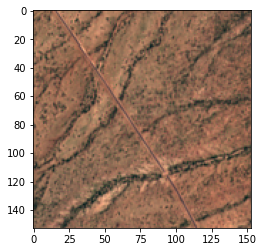

In [ ]:
for root,_,img_names in os.walk(before_img_path):
    for img in img_names: 
        path = os.path.join(root,img)
        tiff_image = rio.open(path).read([4,3,2])
        print(tiff_image.shape)
        show(normMinMax(tiff_image))
        break


In [ ]:
images = []
for root,_,img_names in os.walk(before_img_path):

    for img in img_names: 

        path = os.path.join(root,img)
        tiff_image = rio.open(path).read([4,3,2])

        images.append(normMinMax(tiff_image))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


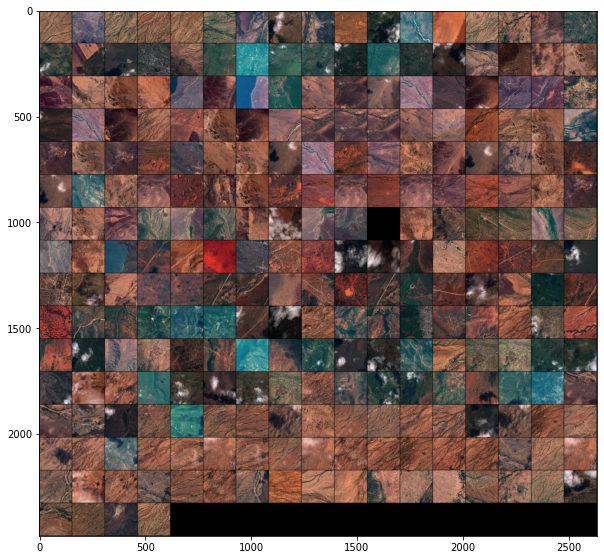

In [ ]:
import torch
from torchvision.utils import make_grid


grid = make_grid(torch.tensor(images),nrow = 17)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))


In [ ]:
!ls

cifar-10  euroSAT	kenya_jepg2  models	       selflabel.py  utils
configs   eval.py	kenya_jpeg   requirements.txt  setup.py
data	  KenyaDataset	losses	     scan.py	       simclr.py


In [ ]:
# #saving images in kenya_jpeg folder 

# folder = 'kenya_jepg/'


# for i,img in enumerate(images):
#     plt.imsave(folder + f'images_{i}.jpeg',img.transpose(1,2,0).astype('uint8'))



# Pretext  + Kmeans 

In [ ]:
!python simclr.py --config_env configs/env.yml --config_exp configs/pretext/simclr_kenya.yml

In [ ]:
import torch


train_dir = "./KenyaModel_8CLS"


pretrain_path = train_dir + "/pretext/model.pth.tar"

state_dict = torch.load(pretrain_path)


from models.models import ContrastiveModel
from models.resnet_cifar import resnet18
backbone = resnet18()
model = ContrastiveModel(backbone,head='mlp',features_dim=128)
        # model = ContrastiveModel(backbone, **p['model_kwargs'])
model.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/pretext/simclr_kenya.yml')
transforms = get_val_transformations(p)
print(transforms)
train_dataset = get_train_dataset(p, transforms)
loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


model = model.cuda()
model.eval()


data_file = {'pred':[]}

for data in tqdm(loader):
    data_file['pred'].append(model(data['image'].cuda()).cpu().detach().numpy())
    


  0%|          | 0/259 [00:00<?, ?it/s]

Compose(
    CenterCrop(size=(153, 153))
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
)
loading kenya dataset ....



100%|██████████| 259/259 [00:04<00:00, 59.27it/s]


In [ ]:
!pwd

/content/drive/MyDrive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN


In [ ]:
pca_images = []
# /content/drive/MyDrive/Omdena/Unsupervised Methods/Unsupervised-Classification/SCAN/kenya_jpeg/image_0.jpeg
from PIL import Image 

folder = 'kenya_jpeg/'

for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    pca_images.append(np.array(img).reshape(1,-1))

pca_images = np.vstack(pca_images)
pca_images.shape

(259, 70227)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
dims = pca.fit_transform(pca_images)

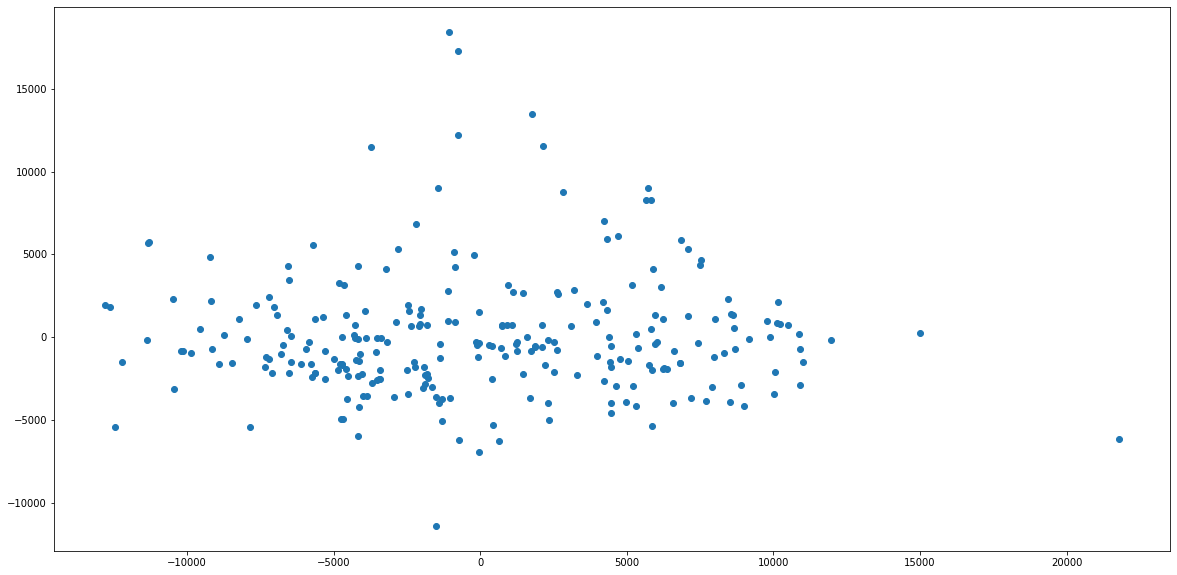

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(dims[:,0],dims[:,1])

# Kmeans 

In [ ]:
kmeans_data = np.vstack(data_file['pred'])
kmeans_data.shape

(259, 128)

In [ ]:
from sklearn.cluster import KMeans  


kmeans = KMeans(n_clusters = 8)
kmeans.fit(kmeans_data)

labels = kmeans.labels_


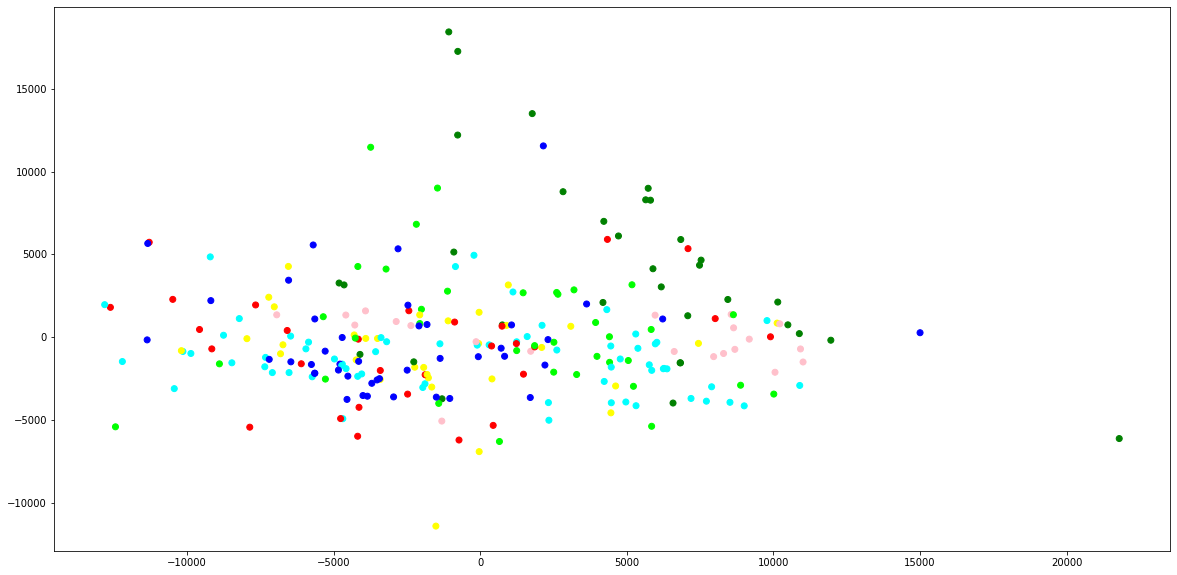

In [ ]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['pink','red','green','blue','yellow','lime','cyan'])

plt.figure(figsize=(20,10))
plt.scatter(dims[:,0],dims[:,1],c = labels,cmap = colors)
  # plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [ ]:
folder = 'kenya_jpeg/'

images = []
for i in os.listdir(folder):

    img_path = os.path.join(folder + i)
    img = Image.open(img_path)
    img = np.array(img)
    images.append(img)
  



In [ ]:
np.asarray(images).shape

(259, 153, 153, 3)

In [ ]:
labels

array([6, 4, 3, 6, 6, 3, 5, 0, 5, 1, 2, 5, 0, 3, 5, 4, 5, 5, 0, 1, 2, 3,
       2, 2, 1, 2, 2, 2, 2, 0, 1, 7, 4, 6, 7, 1, 6, 6, 2, 5, 2, 2, 1, 7,
       0, 6, 1, 7, 7, 2, 5, 7, 6, 7, 3, 4, 6, 7, 1, 7, 7, 7, 1, 1, 1, 6,
       6, 2, 7, 6, 7, 3, 7, 6, 6, 0, 6, 3, 1, 6, 4, 0, 4, 6, 4, 0, 5, 6,
       4, 4, 5, 6, 5, 1, 4, 1, 4, 1, 3, 1, 6, 7, 4, 6, 7, 5, 2, 5, 4, 0,
       2, 2, 3, 6, 7, 5, 7, 5, 3, 5, 6, 1, 5, 7, 4, 2, 3, 3, 0, 0, 5, 1,
       4, 7, 4, 0, 5, 7, 1, 4, 4, 2, 7, 3, 5, 5, 2, 2, 7, 7, 7, 2, 5, 3,
       5, 5, 2, 2, 2, 7, 0, 3, 5, 5, 5, 4, 4, 3, 4, 1, 6, 0, 4, 4, 5, 5,
       2, 4, 2, 0, 0, 2, 1, 3, 3, 2, 0, 4, 1, 3, 2, 7, 0, 7, 3, 3, 5, 2,
       5, 5, 4, 2, 2, 1, 1, 1, 0, 3, 2, 3, 1, 5, 6, 6, 3, 3, 3, 0, 5, 3,
       6, 4, 3, 5, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 4, 6, 6, 3, 4, 3, 4,
       1, 3, 4, 3, 1, 6, 5, 6, 6, 3, 6, 6, 0, 1, 3, 4, 3], dtype=int32)

# Scatter plot with Images 

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import annotate

def imscatter(x, y, labels,images, ax=None, zoom=0.3):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0,l in zip(x, y, images,labels):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        bc = annotate(str(l),(x0,y0),xycoords='data',c = colors[l],fontweight = "extra bold",fontsize = "xx-large")
        artists.append(ax.add_artist(ab))
        artists.append(ax.add_artist(bc))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

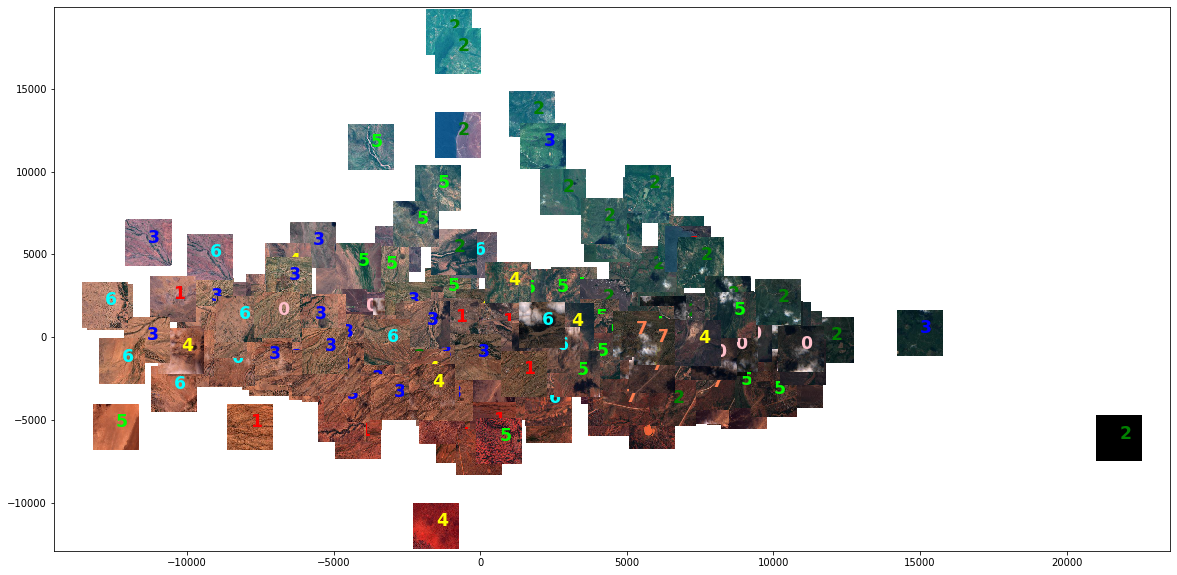

In [ ]:


colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
plt.figure(figsize=(20,10))
imscatter(dims[:,0],dims[:,1],labels,images)
plt.savefig("kmeans.jpg")

In [ ]:
pd.Series(labels).value_counts()

3    43
6    37
5    36
2    33
4    32
1    29
7    28
0    21
dtype: int64

In [ ]:
np.save('kmeans_labels',labels)

# SCAN 

In [ ]:
!python scan.py --config_env configs/env.yml --config_exp configs/scan/scan_kenya.yml

{'setup': 'scan', 'train_dir': 'kenyaModel', 'criterion': 'scan', 'criterion_kwargs': {'entropy_weight': 10.0}, 'update_cluster_head_only': False, 'num_heads': 1, 'backbone': 'resnet18', 'train_db_name': 'KenyaDataset', 'num_classes': 8, 'num_neighbors': 5, 'augmentation_strategy': 'simclr', 'augmentation_kwargs': {'random_resized_crop': {'size': 153, 'scale': [0.2, 1.0]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.4, 'hue': 0.1}, 'random_grayscale': {'p': 0.2}, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'transformation_kwargs': {'crop_size': 153, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'optimizer': 'adam', 'optimizer_kwargs': {'lr': 0.0001}, 'epochs': 103, 'batch_size': 32, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './KenyaDataset/pretext', 'pretext_checkpoint': './KenyaDataset/pretext/checkpoint.pth.tar', 'pretext_model': 

# Load the trained models for validation.

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch


path = train_dir + '/scan/model.pth.tar'

print('Model path : ',path)

state_dict = torch.load(path)

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 8, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()


Model path :  ./KenyaModel_8CLS/scan/model.pth.tar


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:

#getting the config
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/scan/scan_kenya.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transforms)

loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=1)


data_file = {'index':[],'pred':[]}

for idx,data in enumerate(loader):
  
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    data_file['index'].append(idx)

loading kenya dataset ....


In [ ]:
pred_df = pd.DataFrame(data_file)

pred_df['pred'].value_counts()

7    48
0    46
5    43
1    35
4    27
3    25
6    19
2    16
Name: pred, dtype: int64

In [ ]:
# pred_df.to_csv('SCAN_preds.csv',index = False)

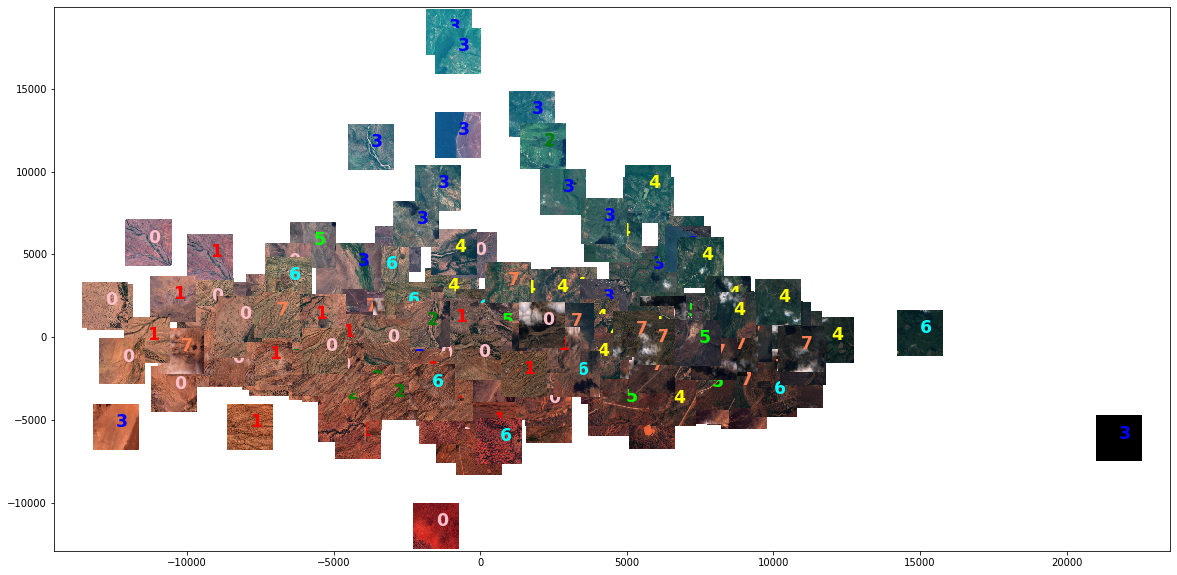

In [ ]:
colors = ['pink','red','green','blue','yellow','lime','cyan','coral']
   
plt.figure(figsize=(20,10))
imscatter(dims[:,0],dims[:,1],pred_df['pred'].values,images)
# plt.savefig("scan_labels.jpg")

# Creating 8 Folders. One for each cluster and then try to manually identify the cluster  (optional)

Classes = [ Annual Cropland,Perennial cropland,open grassland, wooded  grasslands, forestland, openwater,bare soil, otherland.]


## Creating  folders 

In [ ]:
root = 'Pseudo Labels'
os.mkdir(root)

In [ ]:
for i in range(8):
    os.mkdir(f'{root}/{i}')

In [ ]:


p = create_config('configs/env.yml','configs/scan/scan_kenya.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)
train_dataset = get_train_dataset(p, transform = None)


for idx,data in tqdm(enumerate(train_dataset)):

      trax_img = transforms(data['image'])

      folder_name = str(torch.argmax(model(trax_img.unsqueeze(dim = 0).cuda())[0],dim = 1).cpu().detach().numpy()[0])
      
      img_path = root + "/" + folder_name + f"/image_cluster_{folder_name}_{idx}.jpeg" 
  
      img = np.array(data['image'])
    
      plt.imsave(img_path,img)
  

# Reference Labels.

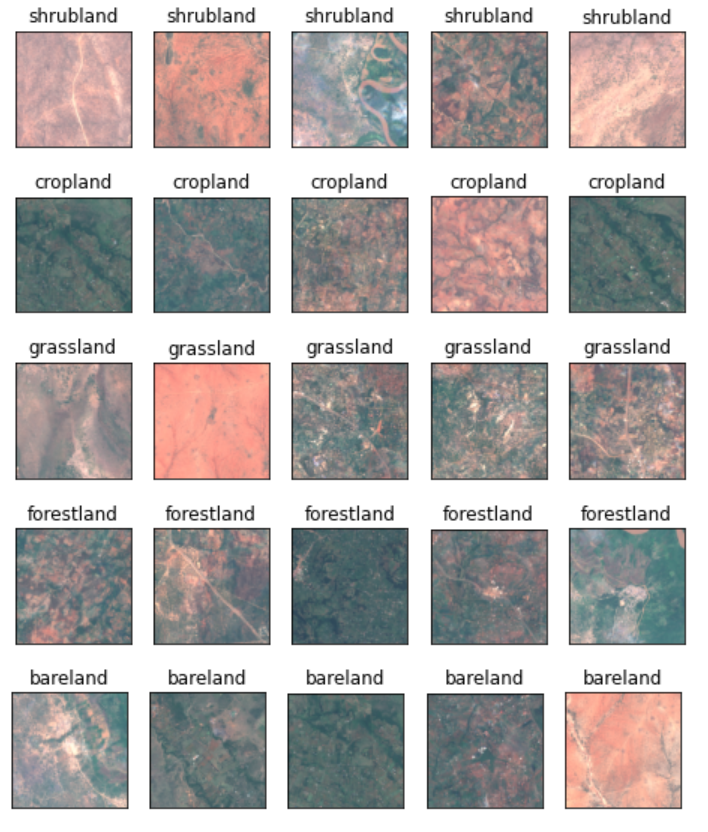

Link to all labels : https://drive.google.com/drive/folders/1TyF06Fa5LMyPoRerzROCfdS5Vqg1OOwu

# Do we have 8 classes or just 5 ? 

# PLotting all the Clusters 

In [ ]:

#helper function. 
def plot_clusters(root,cluster):

   folder = root + f"/{cluster}/"
         
   images = []
   for  img_name in  os.listdir(folder):
       try:
            image_path = folder + img_name 
            # print(img_name)
            img = Image.open(image_path)
            img = np.array(img)
            images.append(np.transpose(np.array(img),(2,0,1)))
       except Exception:
           continue

   grid = make_grid(torch.tensor(images),nrow = 7)
   print(grid.shape)
   plt.figure(figsize=(10,10)) 
   plt.imshow(np.transpose(grid,(1,2,0)))
   plt.savefig(root + "/cluster__0.jpg")


# Cluster 0

torch.Size([3, 1087, 1087])


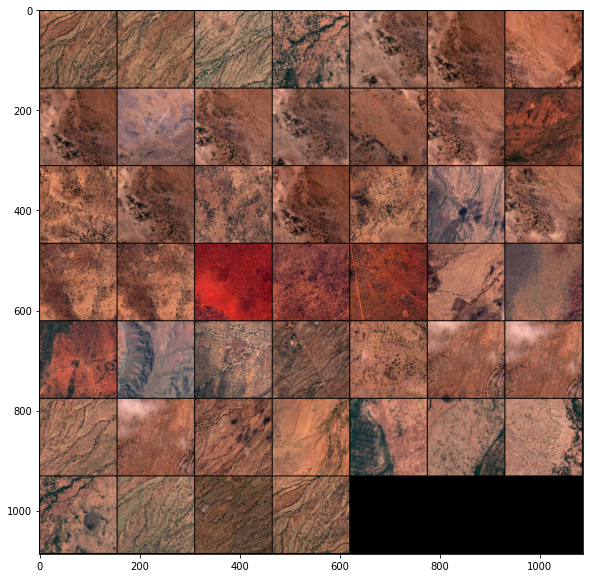

In [ ]:
plot_clusters('Pseudo Labels',0)

# Cluster 1

torch.Size([3, 777, 1087])


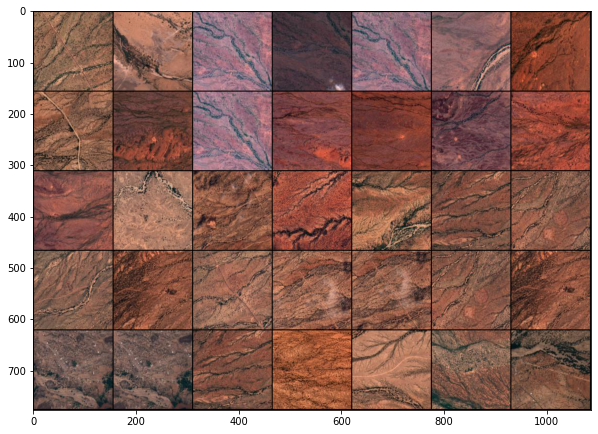

In [ ]:
plot_clusters('Pseudo Labels',1)

torch.Size([3, 467, 1087])


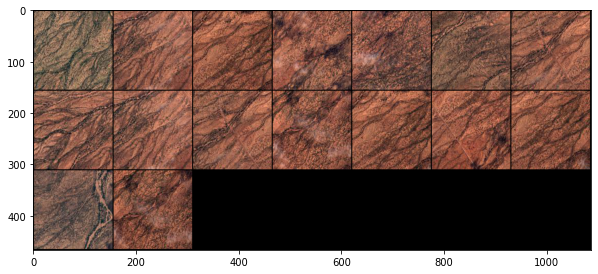

In [ ]:
plot_clusters('Pseudo Labels',2)

torch.Size([3, 622, 1087])


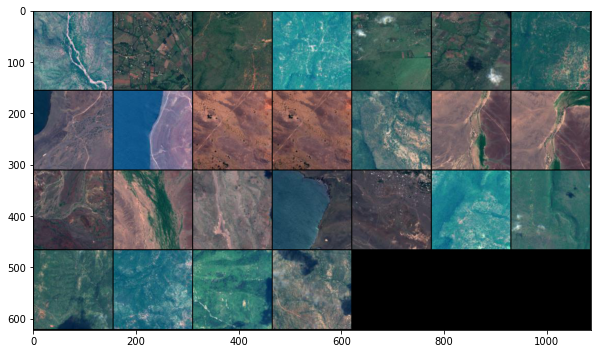

In [ ]:
plot_clusters('Pseudo Labels',3)

torch.Size([3, 622, 1087])


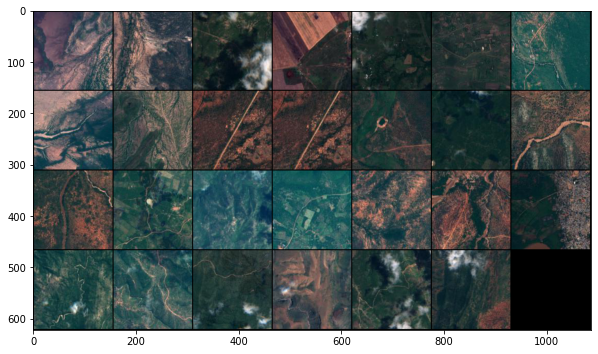

In [ ]:
plot_clusters('Pseudo Labels',4)

torch.Size([3, 1087, 1087])


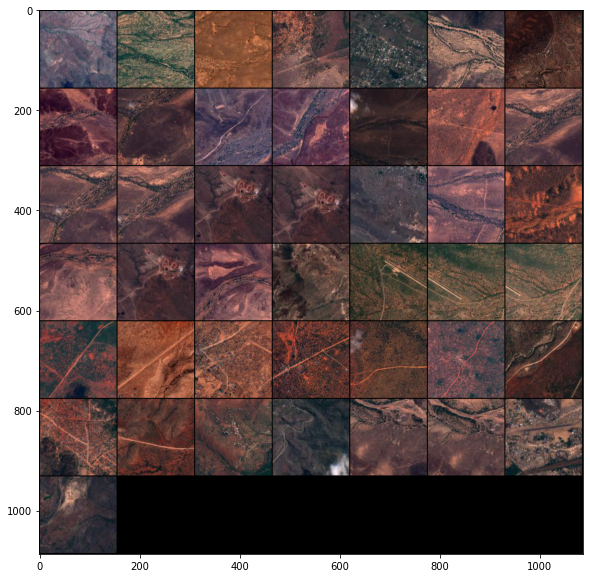

In [ ]:
plot_clusters('Pseudo Labels',5)

#Cluster 6

torch.Size([3, 467, 1087])


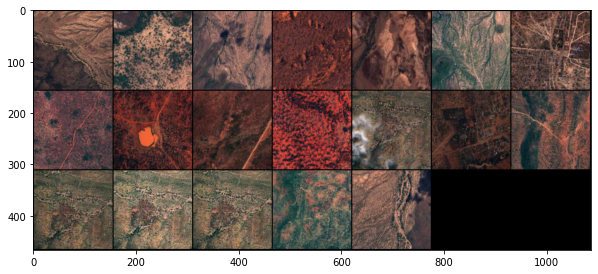

In [ ]:
plot_clusters('Pseudo Labels',6)

torch.Size([3, 1087, 1087])


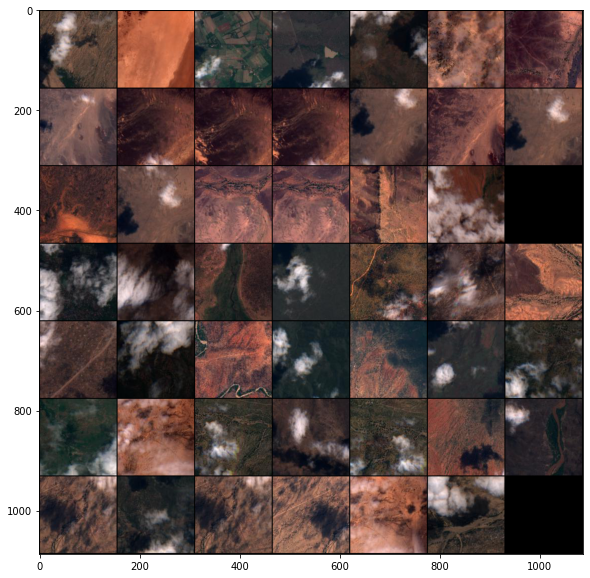

In [ ]:
plot_clusters('Pseudo Labels',7)